# Time Series Analysis & Recurrent Neural Networks
## Final Project
### Lars Kühmichel, Nicolas Wolf

The final project is about analyzing the dynamics of a time series of weather data from across Europe. The goal is to
- reconstruct the dynamics behind the data, especially the annual and daily rhythms
- predict the future of the time series
- and compare two model architectures with respect to the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import seaborn as sns
import torch
import torch.nn as nn
import pytorch_lightning as lightning
import pytorch_lightning.loggers as loggers
from torch.utils.data import DataLoader, Dataset
from scipy.signal import detrend

import ray.tune as tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

In [2]:
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

We first run a modified version of the provided code to download the dataset and save it locally.

In [3]:
def running_mean(x, N):
    w = np.ones(N) / N
    if x.ndim > 1:
        res = []
        for i in range(x.shape[1]):
            res.append(np.convolve(w, x[:, i], 'valid'))
        return np.array(res).T
    else:
        return np.convolve(w, x, 'valid')

In [4]:
data_root = pl.Path("data")
data_root.mkdir(exist_ok=True, parents=True)

data_path = data_root / "weather_data.csv"

if not data_path.is_file():
    data_url = r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv"
    data = pd.read_csv(data_url)
    data.to_csv(data_path)
else:
    data = pd.read_csv(data_path)

The dataset contains hourly geographically aggregated weather (radiation and temperature) data for Europe. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       350640 non-null  int64  
 1   utc_timestamp                    350640 non-null  object 
 2   AT_temperature                   350640 non-null  float64
 3   AT_radiation_direct_horizontal   350640 non-null  float64
 4   AT_radiation_diffuse_horizontal  350640 non-null  float64
 5   BE_temperature                   350640 non-null  float64
 6   BE_radiation_direct_horizontal   350640 non-null  float64
 7   BE_radiation_diffuse_horizontal  350640 non-null  float64
 8   BG_temperature                   350640 non-null  float64
 9   BG_radiation_direct_horizontal   350640 non-null  float64
 10  BG_radiation_diffuse_horizontal  350640 non-null  float64
 11  CH_temperature                   350640 non-null  float64
 12  CH

In [6]:
keys = [
    "FI_temperature",
    "DE_temperature",
    "GR_temperature"
]

test_temp = data[keys]

In [7]:
ten_years = 24 * 365 * 10
tdf = test_temp[-ten_years:]

In [8]:
# weekly mask
week_filter = [True] * 24 + [False] * 24 * 6
# yearly mask for 52 weeks plus one day
year_filter = week_filter * 52 + [True] * 24
# mask for ten years
ten_years_filter = year_filter * 10
daydf = tdf[ten_years_filter]

daydf.shape

(12720, 3)

In [9]:
npa = daydf.to_numpy()

In [10]:
#Moving average to see both trends
N = 24
mnpa = running_mean(npa, N)

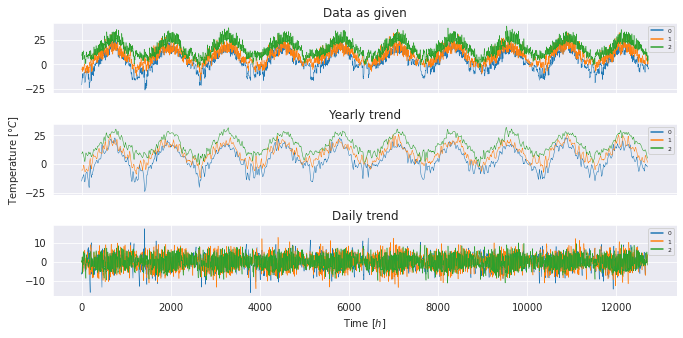

In [11]:
_fig, axes = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=plt.figaspect(1 / 2))
sns.lineplot(data=npa, ax=axes[0], dashes=False, lw=0.5)
axes[0].set_title("Data as given")

sns.lineplot(data=mnpa, ax=axes[1], dashes=False, lw=0.5)
axes[1].set_title("Yearly trend")
axes[1].set_ylabel("Temperature $[°C]$")

sns.lineplot(data=npa[:-N + 1] - mnpa, ax=axes[2], dashes=False, lw=0.5)
axes[2].set_title("Daily trend")
axes[2].set_xlabel("Time $[h]$")

plt.tight_layout()

## Project Tasks

### 1. Split the time series into a train set containing approximately the first 8 years, and a test set containing the last 2 years.

In [12]:
pivot = int(0.8 * len(npa))

train_data, test_data = npa[:pivot], npa[pivot:]

train_data.shape, test_data.shape

((10176, 3), (2544, 3))

### We also modify the data to allow for better training. The same modifications can be applied to any new incoming data, or reversed on the original data, so they do not influence our ability to predict real temperatures.

First, detrend the data. This is useful because
1. our models may assume stationarity
2. we do not want effects like global climate change to influence our model weights.

In [13]:
train_data = detrend(train_data, axis=0)
test_data = detrend(test_data, axis=0)

Then, normalize to zero mean and unit variance based on the training set. This is useful because
1. It allows us to sensibly initialize model weights
2. Model weights (and thus gradients) will remain within a normalized range, smoothing training

In [14]:
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

train_data = (train_data - mean[None]) / std[None]
test_data = (test_data - mean[None]) / std[None]

Show the modified data

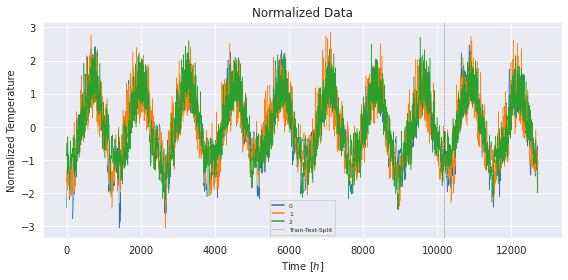

In [15]:
plt.figure(figsize=plt.figaspect(1 / 2))
data = np.concatenate((train_data, test_data), axis=0)
sns.lineplot(data=data, dashes=False, lw=0.5)
plt.axvline(len(train_data), color="black", alpha=0.5, lw=0.5, ls="--", label="Train-Test-Split")

plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")
plt.title("Normalized Data")
plt.legend()

plt.tight_layout()

### 2. Implement a linear latent space model

consisting of a latent VAR(1):
$$
z_{t + 1} = A z_t + \epsilon_t , \quad \epsilon_t \sim \mathcal{N}(0, \Sigma) , \quad z_0 \sim \mathcal{N}(\mu_0, \Sigma)
$$

coupled with a linear observation equation:
$$
x_t = B z_t + \eta_t , \quad \eta_t \sim \mathcal{N}(0, \Gamma)
$$

In [16]:
...  # TODO

Ellipsis

Create some summary and results dataframes for analysis later

In [17]:
summary = pd.DataFrame(columns=["model_name", "train_mse", "validation_mse"])
countries = ["FI", "DE", "GR"]
columns = pd.MultiIndex.from_product([["actual"], countries])
train_predictions = pd.DataFrame(data=train_data, columns=columns.copy())
validation_predictions = pd.DataFrame(data=test_data, columns=columns.copy())

In [18]:
summary.head()

,model_name,train_mse,validation_mse


In [19]:
train_predictions.head()

actual                    
         FI        DE        GR
0 -2.406694 -1.589150 -0.804909
1 -2.425204 -1.579953 -0.839934
2 -2.428143 -1.580719 -0.861752
3 -2.410838 -1.578165 -0.869990
4 -2.364361 -1.583728 -0.874615

### 3. Use a deterministic LSTM coupled with a fully connected observation layer and optimize it with backpropagation through time

First, we define a custom dataset for the LSTM

In [20]:
class TimeSeriesDataset(Dataset):
    """
    Time Series Dataset where each item is a fixed-length sequence within the time series
    """
    def __init__(self, time_series: torch.Tensor, sequence_length: int):
        """
        Initialize the Time Series Dataset
        :param time_series: torch.Tensor of shape (T, ...)
        :param sequence_length: Integer defining the sequence length of each item (sub-time-series)
        """
        self.time_series = time_series
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time_series) - 2 * self.sequence_length + 1

    def __getitem__(self, item: int):
        """
        :return:
            x: input sub-sequence
            y: target sub-sequence of same length, directly after x
        """
        x = self.time_series[item:item + self.sequence_length]
        y = self.time_series[item + self.sequence_length:item + 2 * self.sequence_length]
        return x, y

train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(test_data, dtype=torch.float32)

We use `pytorch-lightning` to define the model, train loop, etc.

In [21]:
class LSTM(lightning.LightningModule):
    """
    Lightning Module which contains a Long Short-Term Memory RNN
    This Module defines
    - The LSTM neural network along with an observation layer
    - The loss criterion
    - The train loop
    - The validation loop
    - The train and validation datasets
    - The train and validation dataloaders
    - The optimizers and learning rate schedulers
    - Several train callbacks
    """
    def __init__(self, train_data: torch.Tensor, val_data: torch.Tensor, **hparams) -> None:
        """
        Initialize the LSTM LightningModule
        :param train_data: Time series tensor which is passed to a TimeSeriesDataset
        :param val_data: Time series tensor which is passed to a TimeSeriesDataset
        :param hparams: Other hyperparameters (see below)
        """
        super().__init__()
        # save all hyperparameters so that we can trivially load models with the correct configuration
        self.save_hyperparameters(hparams, ignore=["train_data", "val_data"])

        # construct the time series datasets
        self.train_data = TimeSeriesDataset(train_data, self.hparams.sequence_length)
        self.val_data = TimeSeriesDataset(val_data, self.hparams.sequence_length)

        # construct LSTM with given hyperparameters
        self.lstm = nn.LSTM(self.hparams.input_size, self.hparams.hidden_size, self.hparams.num_layers, dropout=self.hparams.dropout, batch_first=True)
        # we set a fixed observation net depth; width is based on hyperparameters
        self.observation_net = nn.Sequential(
            nn.Linear(self.hparams.hidden_size, self.hparams.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hparams.hidden_size, self.hparams.input_size),
        )

        # initial predictions close to 0 are good, since we normalized the data
        self.observation_net[-1].weight.data.fill_(0.0)
        self.observation_net[-1].bias.data.fill_(0.0)

        # define the loss criterion used in training
        self.loss = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward step of the LSTM and observation layer
        :param x: Input Tensor (batch of time series)
        :return: Output Tensor (batch of predicted observations)
        """
        z, _ = self.lstm.forward(x)
        y = self.observation_net.forward(z)

        return y

    def training_step(self, batch: torch.Tensor, batch_idx: torch.Tensor) -> torch.Tensor:
        """
        Define a single training step for the LSTM and observation layer
        We just need to calculate and return the loss, lightning handles backpropagation and everything else
        This method will be called in trainer.fit() later
        :param batch: Input Tensor (batch of time series)
        :param batch_idx: Index of Batch (unused)
        :return: Scalar Loss Tensor
        """
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss(yhat, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Define a single validation step for the LSTM and observation layer
        We just want to calculate and log the loss, otherwise this is equivalent to training_step
        :param batch: Input Tensor (batch of time series)
        :param batch_idx: Index of Batch (unused)
        :return: None
        """
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss(yhat, y)

        self.log("val_loss", loss)

    def predict(self, x:  torch.Tensor, hx=None, steps: int = 1):
        """
        Run multiple predictions and concatenate
        :param x: Input Tensor (batch of time series)
        :param hx: Hidden State
        :param steps: Number of steps to predict
        :return: Concatenated predictions, shape will be (batch_size, steps * self.hparams.sequence_length, ...)
        """
        predictions = []
        x = x[:, -self.hparams.sequence_length:].to(self.device)

        for _ in range(steps):
            z, hx = self.lstm.forward(x, hx)
            x = self.observation_net(z).detach()

            predictions.append(x)

        return torch.cat(predictions, dim=1)

    def forecast(self, steps: int = 1):
        """
        Forecast a number of prediction steps starting from the end of the training set
        :param steps: Number of steps to forecast
        :return: Concatenated forecasts, shape will be (1, steps * self.hparams.sequence_length, ...)
        """
        return self.predict(self.train_data.time_series[None], steps=steps).squeeze()

    def simulate(self, batch_size: int = 1, steps: int = 1, data: torch.Tensor = None):
        """
        Simulate a new time series, drawing initial conditions randomly from the training set
        :param batch_size: Number of time series to generate
        :param steps: Number of steps to generate for each time series
        :return: Concatenated time series, shape will be (batch_size, steps * self.hparams.sequence_length, ...)
        """
        if data is None:
            data = self.train_data.time_series

        starts = torch.randint(low=0, high=len(data) - self.hparams.sequence_length, size=(batch_size,))
        stops = starts + self.hparams.sequence_length
        # unfortunately, this cannot be done without a loop
        xs = []
        for start, stop in zip(starts, stops):
            x = data[start:stop]
            xs.append(x)
        x = torch.stack(xs, dim=0)

        return self.predict(x, steps=steps)

    def configure_optimizers(self):
        """
        Configure optimizers and lr schedulers for lightning
        """
        match self.hparams.optimizer.lower():
            case "adam":
                optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
            case "rmsprop":
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.hparams.optimizer} is not supported.")

        lr_warmup = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_warmup_milestones, self.hparams.lr_warmup_gamma)
        lr_step = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_milestones, self.hparams.lr_gamma)
        lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler([
            lr_warmup,
            lr_step,
        ])
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

    def configure_callbacks(self):
        """
        Configure callbacks for lightninng
        """
        return [
            # this saves the best and last model (best is defined by validation loss)
            lightning.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True),
            # this logs the learning rate, so we can view it in tensorboard
            lightning.callbacks.LearningRateMonitor(),
            # SWA is a form of zero-cost regularization
            lightning.callbacks.StochasticWeightAveraging(swa_epoch_start=self.hparams.swa_start, swa_lrs=self.hparams.swa_lr, device=None),
        ]

    def train_dataloader(self):
        """
        Configure and return the train dataloader for lightning
        """
        return DataLoader(
            dataset=self.train_data,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
        )

    def val_dataloader(self):
        """
        Configure and return the validation dataloader for lightning
        """
        return DataLoader(
            dataset=self.val_data,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=4,
        )

We run a hyperparameter search using `ray[tune]`'s `ASHA`, which runs multiple configurations sampled randomly from the parameter space and stops poorly performing trials early to save resources. We come up with the following results:


| Parameter Name         | Description                                                                         | Effect                                                                                                                                       | Searched Space      | Optimal Value  |
|------------------------|-------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|---------------------|----------------|
| `input_size`           | Given by the number of tracked temperatures                                         | -                                                                                                                                            | -                   | 3              |
| `hidden_size`          | Defines the size of the latent space for the LSTM                                   | Large Latent spaces can capture the target function better, but require more memory, are slower to train and prone to overfit                | 60 - 360[^1]        | 120            |
| `num_layers`           | Defines the number of layers for the LSTM                                           | Similar to `hidden_size`                                                                                                                     | 2 - 6[^1]           | 4              |
| `dropout`              | Controls the Dropout probability for within the LSTM                                | Regularization, counteracts overfitting                                                                                                      | 0 - 0.5             | ~0.4           |
| `weight_decay`         | Controls strength of $L^2$ regularization                                           | Regularization, counteracts overfitting                                                                                                      | 1e-4 - 1e-2         | ~3e-4          |
| `batch_size`           | Number of sub-sequences to train on in parallel                                     | Larger batch sizes smooth the loss landscape, but slow training since more computations must be made for the same number of gradient updates | 4 - 64              | 4              |
| `optimizer`            | Algorithm to optimize the parameter set                                             | Adam might not converge for some parameter sets, RMSprop is suited for use with gradients of greatly different magnitudes                    | "adam", "rmsprop"   | "adam"         |
| `learning_rate`        | Defines the (default) step-size of the optimizer                                    | Larger learning rates speed training, but the network may not converge at all if the learning rate is too big                                | 1e-4 - 1e-2         | ~1e-4          |
| `gradient_clip`        | Defines the value at which gradient-norm will be clipped                            | May help smooth very noisly loss landscapes                                                                                                  | -                   | None           |
| `sequence_length`      | Defines the length of the sub-sequence the RNN trains on and predicts               | Must be large enough to capture periodicities in the dataset, but we are limited by the size of the train and validation set.                | 1 month - 12 months | 7 months (672) |
| `lr_warmup_milestones` | Defines epochs at which to increase the `learning_rate` by factor `lr_warmup_gamma` | May help with numerical stability at the start of training                                                                                   | -                   | []             |
| `lr_warmup_gamma`      | See `lr_warmup_milestones`                                                          | See `lr_warmup_milestones`                                                                                                                   | -                   | 10.0           |
| `lr_milestones`        | Defines epochs at which to decrease the `learning_rate` by factor `lr_gamma`        | Helps push the network deeper into the local minimum it found at the end of training                                                         | -                   | [40, 45]       |
| `lr_gamma`             | See `lr_milestones`                                                                 | See `lr_milestones`                                                                                                                          | -                   | 0.1            |
| `swa_start`            | Defines epoch at which to start stochastic weight averaging                         | Regularizes weights at the end of training, leading to better test error                                                                     | -                   | 50             |
| `swa_lr`               | Defines the learning rate to use for stochastic weight averaging                    | SWA allows using higher LR                                                                                                                   | -                   | 1e-3           |

[^1]: Optimal parameters may lie outside of this range, but were not searched due to memory constraints.

These are the optimal hyperparameters:

In [22]:
hparams = dict(
    input_size=npa.shape[-1],
    hidden_size=120,
    num_layers=2,
    dropout=0.4,
    weight_decay=1e-4,
    batch_size=4,
    optimizer="adam",
    learning_rate=1e-4,
    gradient_clip=None,
    sequence_length=7 * 4 * 24,
    lr_warmup_milestones=[],
    lr_warmup_gamma=10.0,
    lr_milestones=[40, 45],
    lr_gamma=0.1,
    swa_start=50,
    swa_lr=1e-3,
)

Here is the code to run the hyperparameter search:

In [23]:
def train(hparams, metrics, max_epochs=16, gpus=-1):
    """
    This is the train function used by ray[tune]
    """
    model = LSTM(train_data, val_data, **hparams)

    # use a different save_dir for the logger
    logger = loggers.TensorBoardLogger(
        save_dir=tune.get_trial_dir(), name="", version="."
    )

    # define the lightning trainer with a Tune Report Callback
    trainer = lightning.Trainer(
        max_epochs=max_epochs,
        gpus=gpus,
        callbacks=[
            TuneReportCallback(metrics=metrics, on="validation_end")
        ],
        logger=logger,
        enable_progress_bar=False,
    )

    trainer.fit(model)

    return model

In [24]:
def tune_hparams(config, metrics, num_samples=256, max_epochs=16, cpus_per_trial=3, gpus_per_trial=0.33, resume=False):
    """
    Tune hparams from the given config using ASHA
    :param config: Defines the parameter space
    :param metrics: metrics to evaluate each parameter set
    :param num_samples: how often to sample from the parameter space
    :param max_epochs: number of max epochs to train per parameter set
    :param cpus_per_trial: number of cpu cores to use for each trial (must be positive)
    :param gpus_per_trial: number of gpus to use for each trial (can be fractional)
    :return: Parameter analysis results
    """

    # run for at most 3 minutes
    # in testing we already saw significant overfit after 3 minutes of training
    scheduler = tune.schedulers.AsyncHyperBandScheduler(
        time_attr="time_total_s",
        max_t=3 * 60,
        grace_period=60,
        reduction_factor=4,
    )

    # report progress in a notebook-friendly way
    reporter = tune.JupyterNotebookReporter(
        overwrite=True,
        parameter_columns=list(config.keys()),
        metric_columns=list(metrics.keys()) + ["training_iteration"],
    )

    # bind the train function to given parameters
    train_fn = tune.with_parameters(train, metrics=metrics, max_epochs=max_epochs, gpus=int(np.ceil(gpus_per_trial)))

    # tune.run needs this as a dict
    resources_per_trial = dict(cpu=cpus_per_trial, gpu=gpus_per_trial)

    # run the hyperparameter search
    analysis = tune.run(
        train_fn,
        resources_per_trial=resources_per_trial,
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="ray_results",
        name="tune_asha",
        resume=resume,
    )

    return analysis

Define the space for the parameter search:

In [25]:
# metrics to evaluate parameter configurations
metrics = dict(
    loss="val_loss",
)

config = hparams.copy()
config["optimizer"] = tune.choice(["adam", "rmsprop"])
config["hidden_size"] = tune.choice([60, 120, 240, 360])
config["num_layers"] = tune.choice([1, 2, 4, 6])
config["learning_rate"] = tune.loguniform(1e-4, 1e-2)
# sample between one month (4 weeks * 24 hours) and 12 months, quantized by months
config["sequence_length"] = tune.qrandint(4 * 24, 12 * 4 * 24, 4 * 24)
# sample logarithmically between 4 and 256 with base 4, quantized by steps of 4
config["batch_size"] = tune.qlograndint(4 ** 1, 4 ** 4, 4, 4)
config["dropout"] = tune.uniform(0.0, 0.5)
config["weight_decay"] = tune.loguniform(1e-4, 1e-2)

Uncomment this to run the parameter search. Note that running the full search may take several hours (around 12 hours, tested on a Ryzen 7 5800X CPU with an RTX 2080 GPU). If a trial errors (e.g. due to limited memory), you can restart the search with `resume="ERRORED_ONLY"`.

In [26]:
# analysis = tune_hparams(config, metrics, gpus_per_trial=1, resume="ERRORED_ONLY")
# hparams = analysis.best_config
# print(f"Best hyperparameters found were: {hparams}")

Fully train the model with the best hyperparameters. First show the tensorboard widget to track training:

In [27]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Launching TensorBoard...

Training takes around 10-15 minutes.

In [28]:
model = LSTM(train_data, val_data, **hparams)

trainer = lightning.Trainer(
    max_epochs=70,
    gpus=-1,
)

model.train()
trainer.fit(model)

# we're done with training, so disable autograd for the rest of the notebook
torch.autograd.set_grad_enabled(False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | lstm            | LSTM       | 176 K 
1 | observation_net | Sequential | 14.9 K
2 | loss            | MSELoss    | 0     
-----------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.764     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Swapping scheduler `ChainedScheduler` for `SWALR`


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
# load the best model
model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, train_data=train_data, val_data=val_data)
model.eval()

LSTM(
  (lstm): LSTM(3, 120, num_layers=2, batch_first=True, dropout=0.4)
  (observation_net): Sequential(
    (0): Linear(in_features=120, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=3, bias=True)
  )
  (loss): MSELoss()
)

In [33]:
# get train set predictions
x = model.train_data.time_series[:model.hparams.sequence_length][None]
steps = int(np.ceil(len(train_predictions) / model.hparams.sequence_length))
tp = torch.cat((x, model.predict(x, steps=steps)), dim=1).squeeze()

# truncate predictions to fit dataframe
tp = tp[:len(train_predictions)]

# same for the validation set
steps = int(np.ceil(len(validation_predictions) / model.hparams.sequence_length))
vp = model.forecast(steps=steps)
vp = vp[:len(validation_predictions)]

# find (non-normalized) train and validation mse
train_residuals = tp - model.train_data.time_series
validation_residuals = vp - model.val_data.time_series

std = torch.from_numpy(std)
train_mse = torch.mean((std * train_residuals) ** 2).numpy()
validation_mse = torch.mean((std * validation_residuals) ** 2).numpy()

# add to dataframes (this is convoluted because of multi-indexing, but makes for nice dataframes in the end)
s_entry = pd.DataFrame.from_dict({"model_name": ["LSTM"], "train_mse": [train_mse], "validation_mse": [validation_mse]})
columns = pd.MultiIndex.from_product([["LSTM"], countries])
tp_entry = pd.DataFrame(data=tp.detach().cpu().numpy(), columns=columns.copy())
vp_entry = pd.DataFrame(data=vp.detach().cpu().numpy(), columns=columns.copy())

summary = pd.concat((summary, s_entry), axis=0)
train_predictions = pd.concat((train_predictions, tp_entry), axis=1)
validation_predictions = pd.concat((validation_predictions, vp_entry), axis=1)

TypeError: expected np.ndarray (got Tensor)

### 4. Use your two models to make a prediction of the last 2 years.

First, check the fit on the train set

Text(0.5, 1.0, 'Training Set Fit')

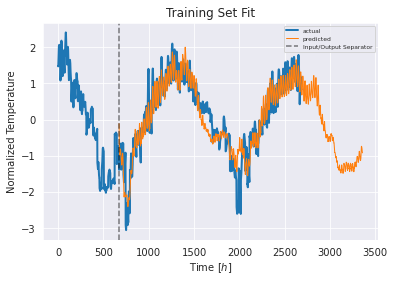

In [34]:
steps = 4

x = model.train_data.time_series[None, model.hparams.sequence_length:(1 + steps) * model.hparams.sequence_length]

xhat = x[:, :model.hparams.sequence_length]
yhat = model.predict(xhat, steps=steps)
yhat = yhat.detach().cpu().numpy()

plt.plot(np.arange(x.shape[1]), x[0, :, 0], lw=2, label="actual")
plt.plot(np.arange(xhat.shape[1], xhat.shape[1] + yhat.shape[1]), yhat[0, :, 0], lw=1, label="predicted")
plt.axvline(model.hparams.sequence_length, color="black", alpha=0.5, ls="--", label="Input/Output Separator")
plt.xlabel("Time $[h$]")
plt.ylabel("Normalized Temperature")
plt.legend()
plt.title("Training Set Fit")

And now on the validation set (last 2 years). We compare the fit for different timescales:

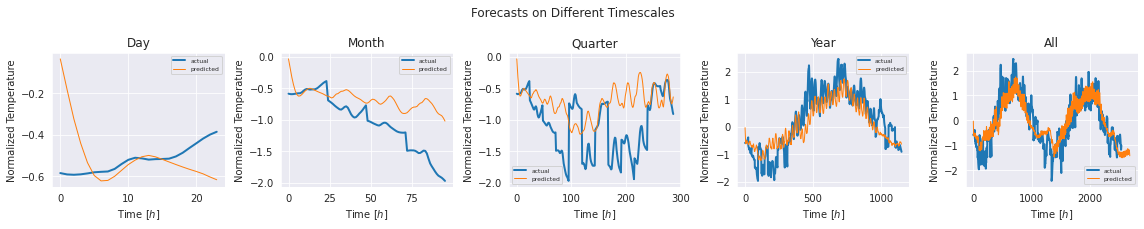

In [35]:
steps = int(round(len(val_data) / model.hparams.sequence_length))
yhat = model.forecast(steps)

titles = ["Day", "Month", "Quarter", "Year", "All"]
endpoints = [24, 4 * 24, 3 * 4 * 24, 12 * 4 * 24, None]

fig, axes = plt.subplots(1, len(titles), figsize=plt.figaspect(1 / len(titles)))

for ax, title, endpoint in zip(axes, titles, endpoints):
    ax.plot(val_data[:endpoint, 0], lw=2, label="actual")
    ax.plot(yhat[:endpoint, 0], lw=1, label="predicted")
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel("Time $[h]$")
    ax.set_ylabel("Normalized Temperature")

fig.suptitle("Forecasts on Different Timescales")
plt.tight_layout()
plt.show()

It appears the LSTM fits well to the yearly cycle, and also captures a daily cycle, but does not fit well on short timescales.

### Compare their Mean Squared Errors

The LSTM is the clear winner in terms of MSE.

In [36]:
summary

,model_name,train_mse,validation_mse
0,LSTM,"tensor(44.2418, dtype=torch.float64)","tensor(17.4660, dtype=torch.float64)"


### Make an expressive plot summarizing your results

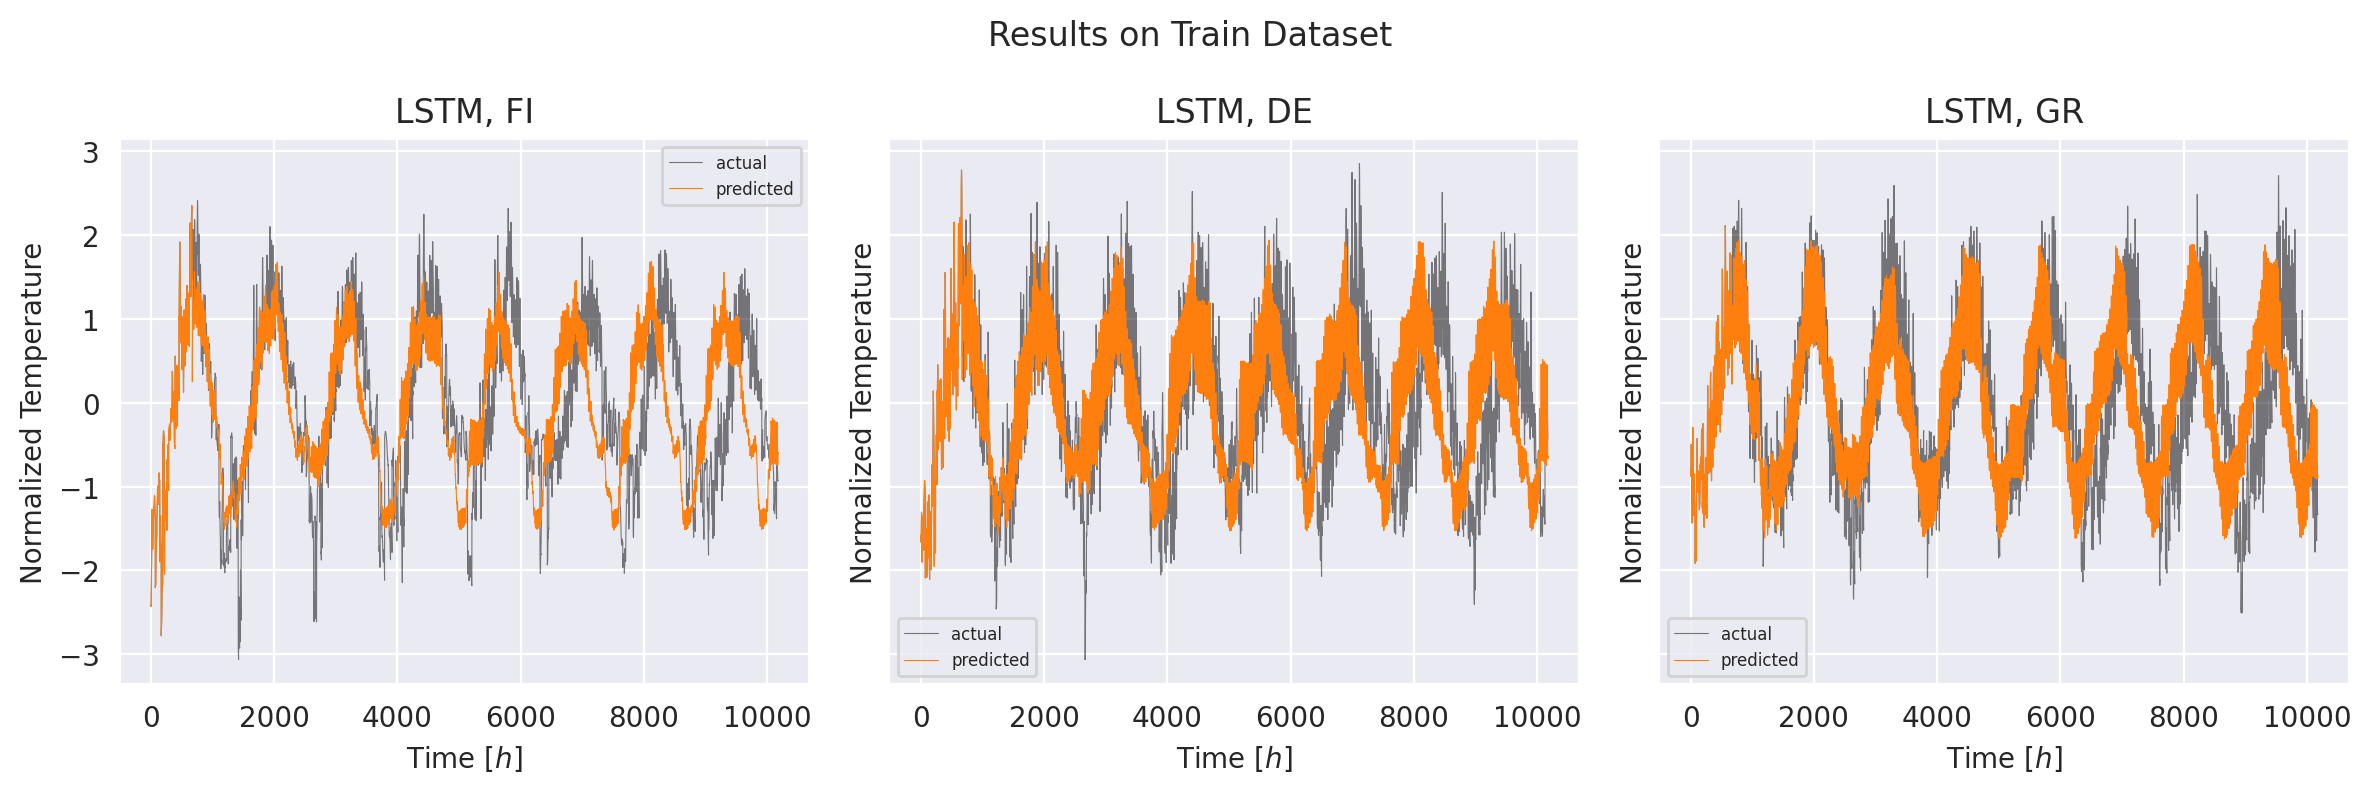

In [37]:
# number of models
nrows = len(summary)
# number of countries
ncols = len(countries)

plt.rc("figure", dpi=200)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=plt.figaspect(nrows / ncols), sharex="all", sharey="row", squeeze=False)

for row, model_name in enumerate(summary["model_name"]):
    for col, country in enumerate(countries):
        ax = axes[row, col]

        actual = train_predictions[("actual", country)]
        predicted = train_predictions[(model_name, country)]
        ax.plot(actual, color="black", alpha=0.5, lw=0.4, label="actual")
        ax.plot(predicted, color="C1", lw=0.4, label="predicted")

        ax.set_title(f"{model_name}, {country}")
        ax.set_xlabel("Time $[h]$")
        ax.set_ylabel("Normalized Temperature")
        ax.legend()

fig.suptitle("Results on Train Dataset")
plt.tight_layout()
plt.savefig("results_train.png")
plt.show()

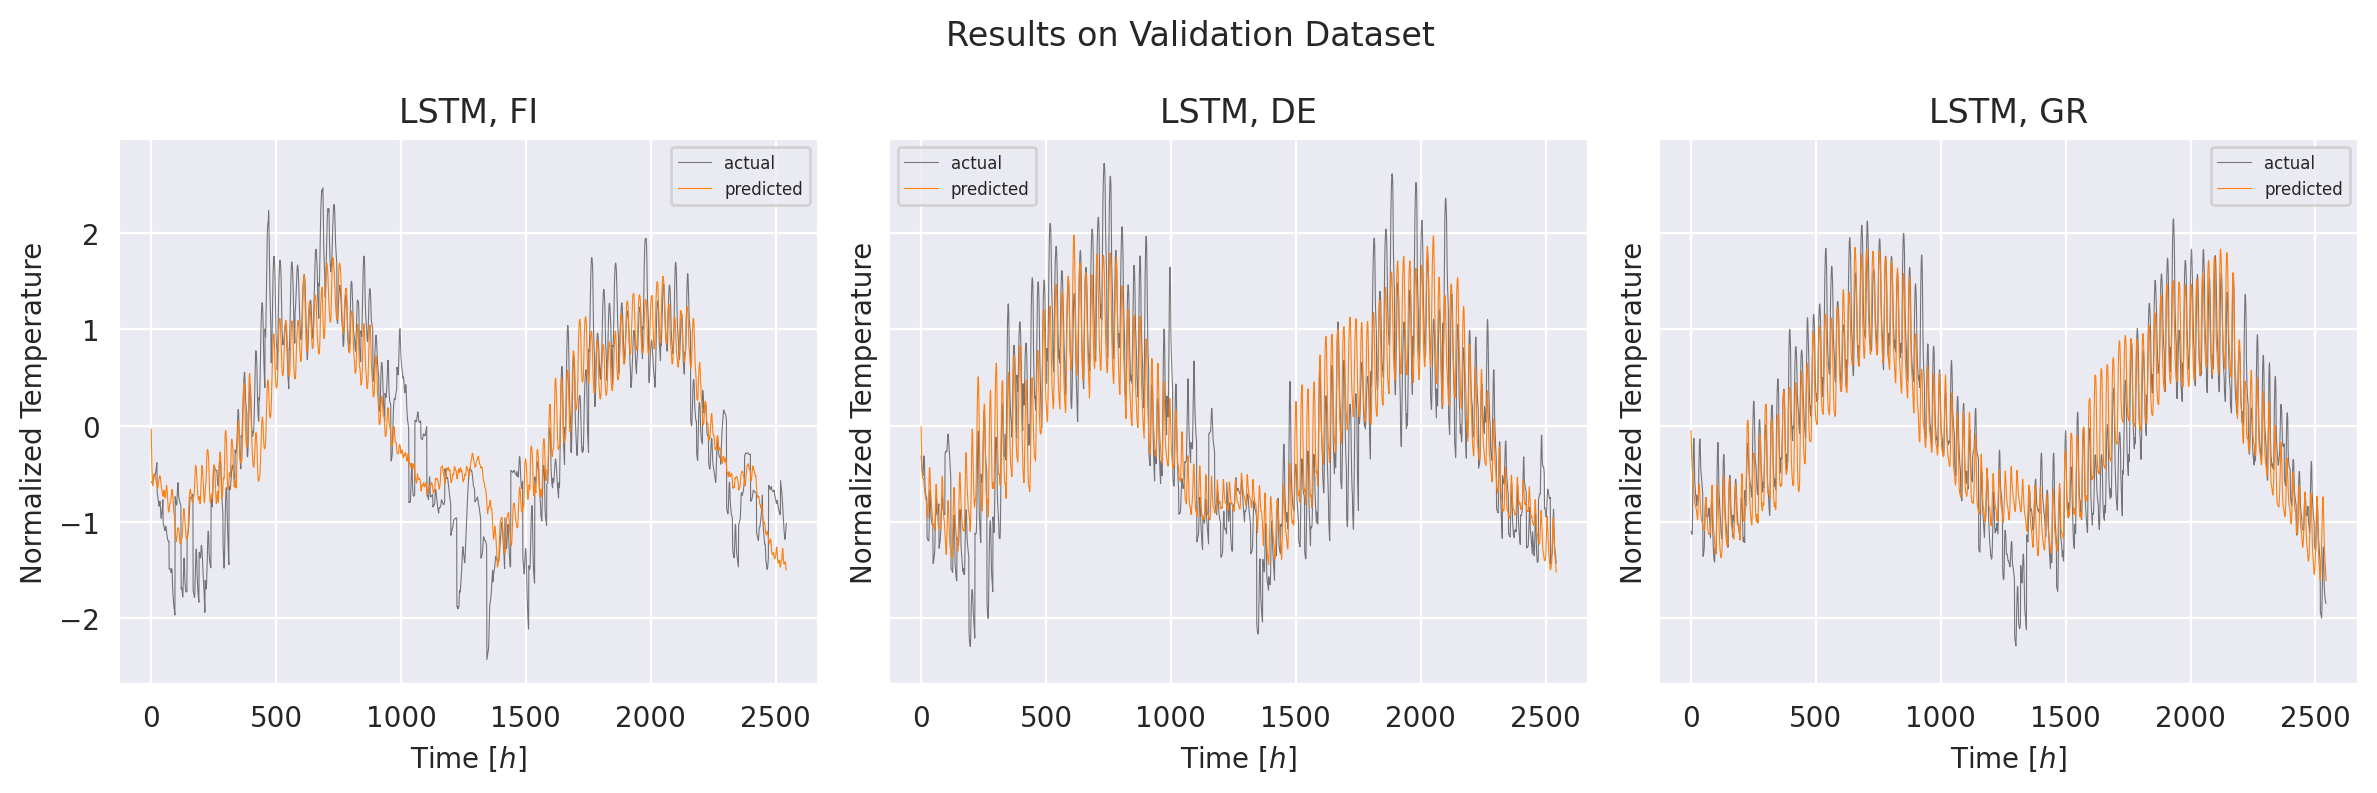

In [38]:
# number of models
nrows = len(summary)
# number of countries
ncols = len(countries)

plt.rc("figure", dpi=200)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=plt.figaspect(nrows / ncols), sharex="all", sharey="row", squeeze=False)

for row, model_name in enumerate(summary["model_name"]):
    for col, country in enumerate(countries):
        ax = axes[row, col]

        actual = validation_predictions[("actual", country)]
        predicted = validation_predictions[(model_name, country)]
        ax.plot(actual, color="black", alpha=0.5, lw=0.4, label="actual")
        ax.plot(predicted, color="C1", lw=0.4, label="predicted")

        ax.set_title(f"{model_name}, {country}")
        ax.set_xlabel("Time $[h]$")
        ax.set_ylabel("Normalized Temperature")
        ax.legend()

fig.suptitle("Results on Validation Dataset")
plt.tight_layout()
plt.savefig("results_val.png")
plt.show()

### 5. Check the DS reconstruction capabilities of your models with the provided powerspectrum correlation metric.

#### 5.1. Implement a routine which draws several random initial conditions from any point in the data and generates time series of length $T$, where $T$ is greater than or equal to one year.

We did this in `model.simulate()`. To simulate at least one year, we need to pass `steps=2` or greater.

In [39]:
ts = model.simulate(steps=2)

ts.shape

torch.Size([1, 1344, 3])

Text(0, 0.5, 'Normalized Temperature')

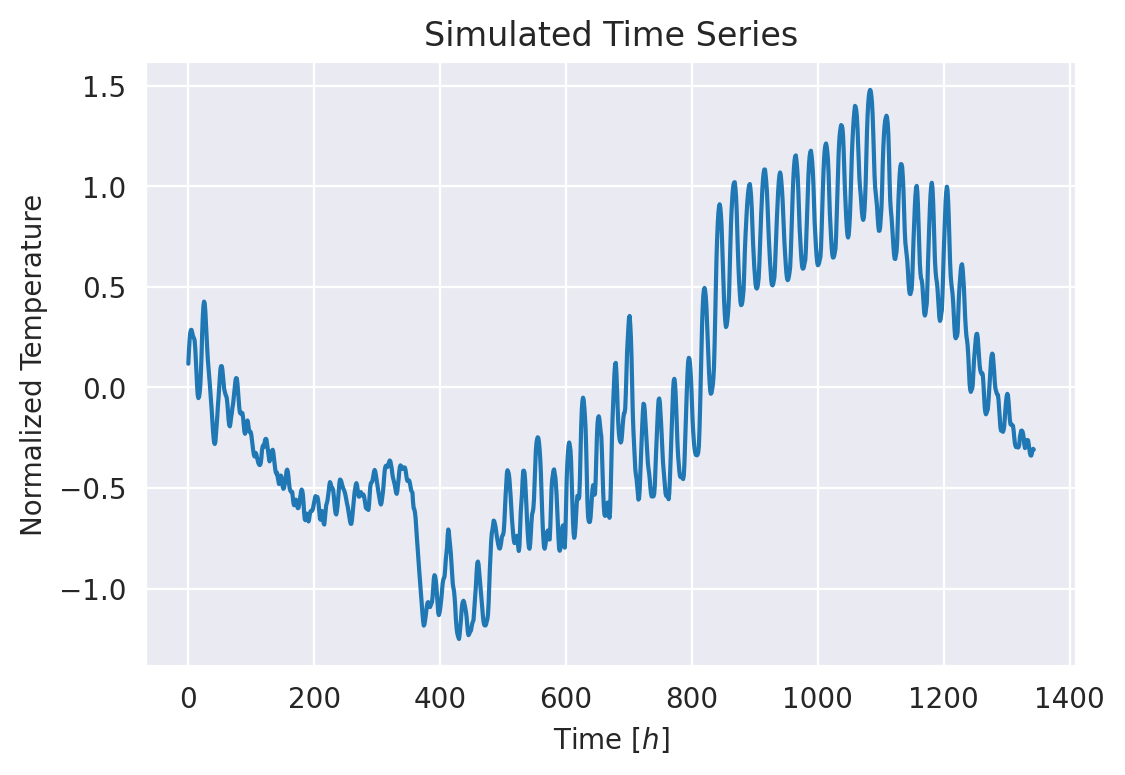

In [40]:
plt.plot(ts[:, :, 0].squeeze())
plt.title("Simulated Time Series")
plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")

Since we want to compare with ground truth, let's copy and modify `model.simulate`:

In [41]:
batch_size = 32
steps = 4

data = torch.cat((model.train_data.time_series, model.val_data.time_series))

starts = torch.randint(low=0, high=len(data) - (steps + 1) * model.hparams.sequence_length, size=(batch_size,))
stops = starts + model.hparams.sequence_length

# unfortunately, this cannot be done without a loop
xs = []
gts = []
for start, stop in zip(starts, stops):
    x = data[start:stop]
    xs.append(x)
    gt = data[stop : stop + steps * model.hparams.sequence_length]
    gts.append(gt)

x = torch.stack(xs, dim=0)
gt = torch.stack(gts, dim=0)

ts = model.predict(x, steps=steps).numpy()

# time series (ts) and ground truth (gt)
ts.shape, gt.shape

((32, 2688, 3), torch.Size([32, 2688, 3]))

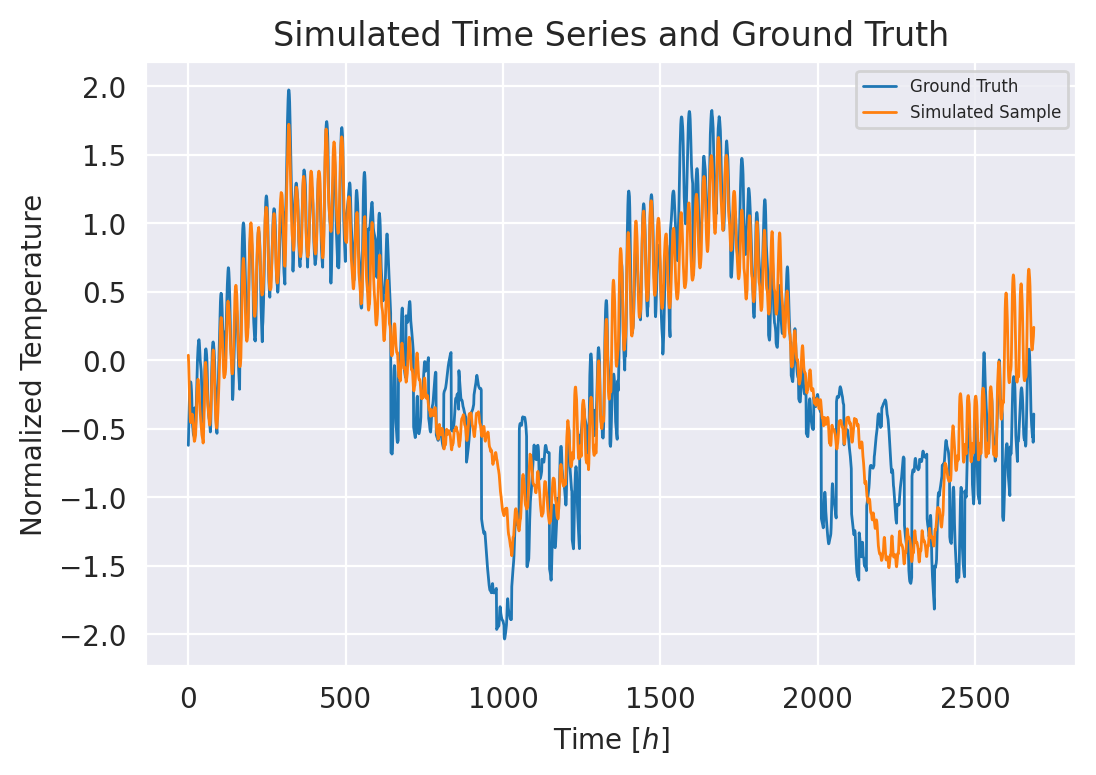

In [42]:
plt.plot(gt[0, :, 0].squeeze(), lw=1, label="Ground Truth")
plt.plot(ts[0, :, 0].squeeze(), lw=1, label="Simulated Sample")
plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")
plt.title("Simulated Time Series and Ground Truth")
plt.legend()

In [43]:
import provided.PSC as psc

psc.SMOOTHING_SIGMA = 1
psc.FREQUENCY_CUTOFF = int(1e9)

def better_plot_spectrum_comparison(s_true, s_gen):
    plt.plot(s_true / s_true.sum(), lw=1, label='ground truth')
    plt.plot(s_gen / s_gen.sum(), lw=1, label='generated')
    #  plt.savefig(".pdf")
    plt.legend()
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

psc.plot_spectrum_comparison = better_plot_spectrum_comparison

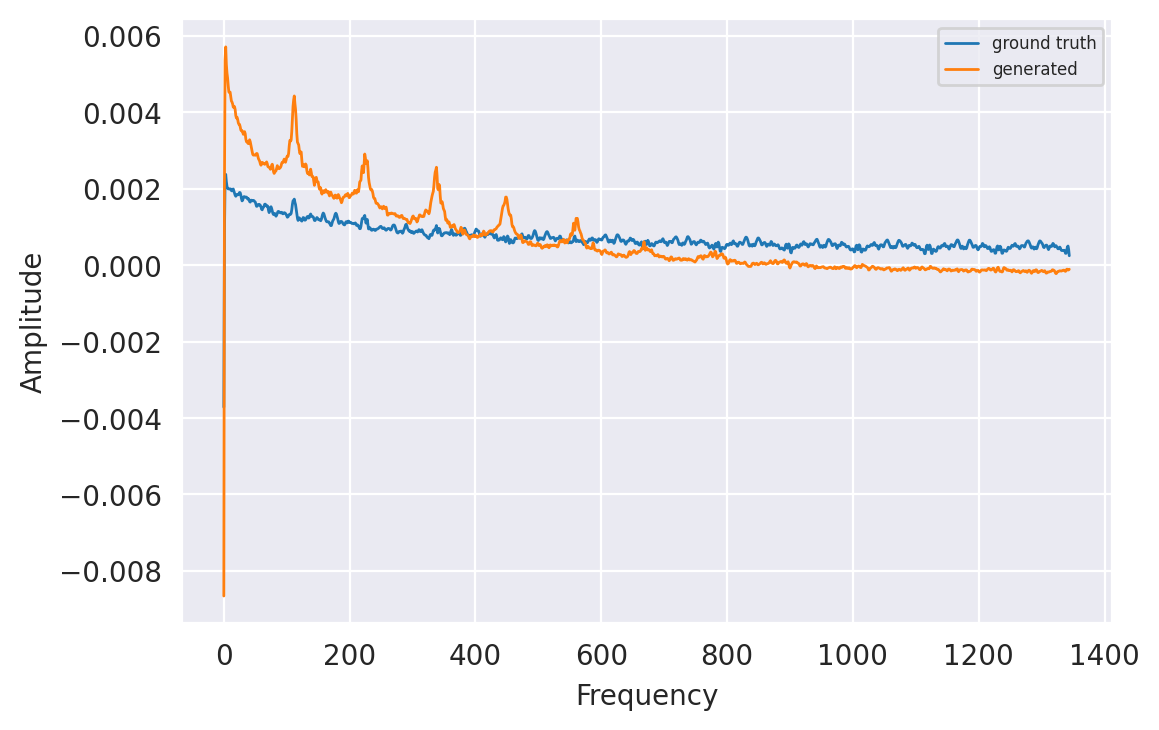

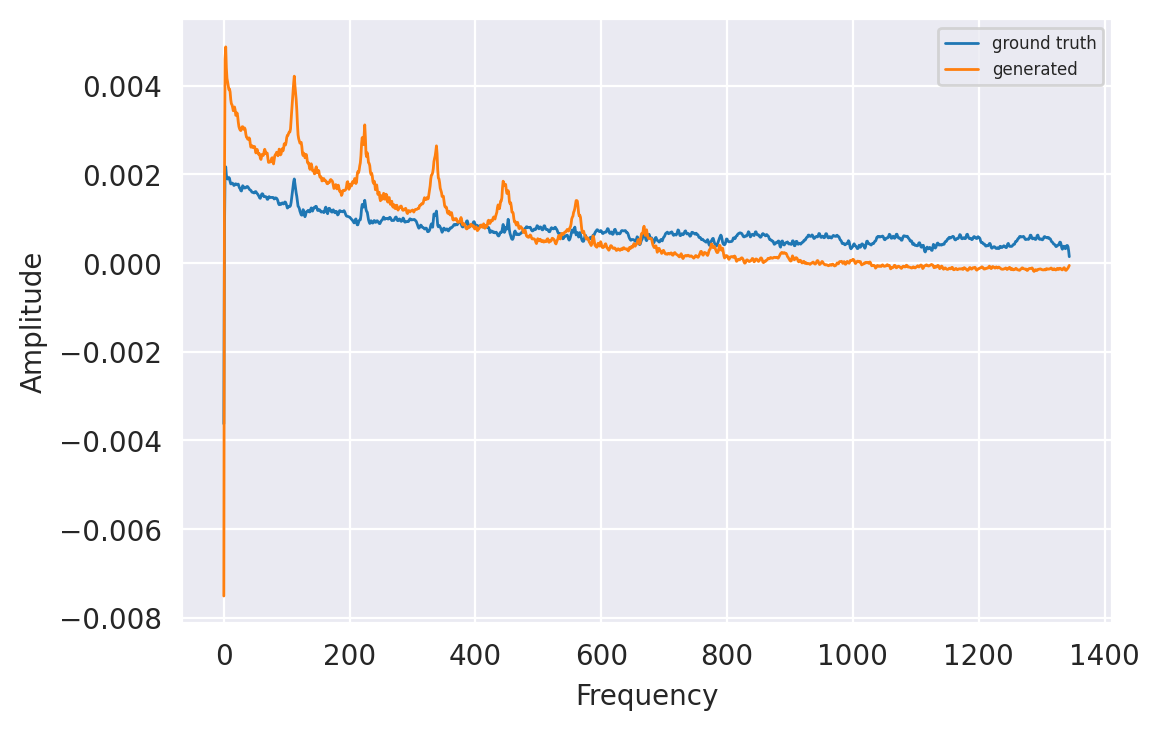

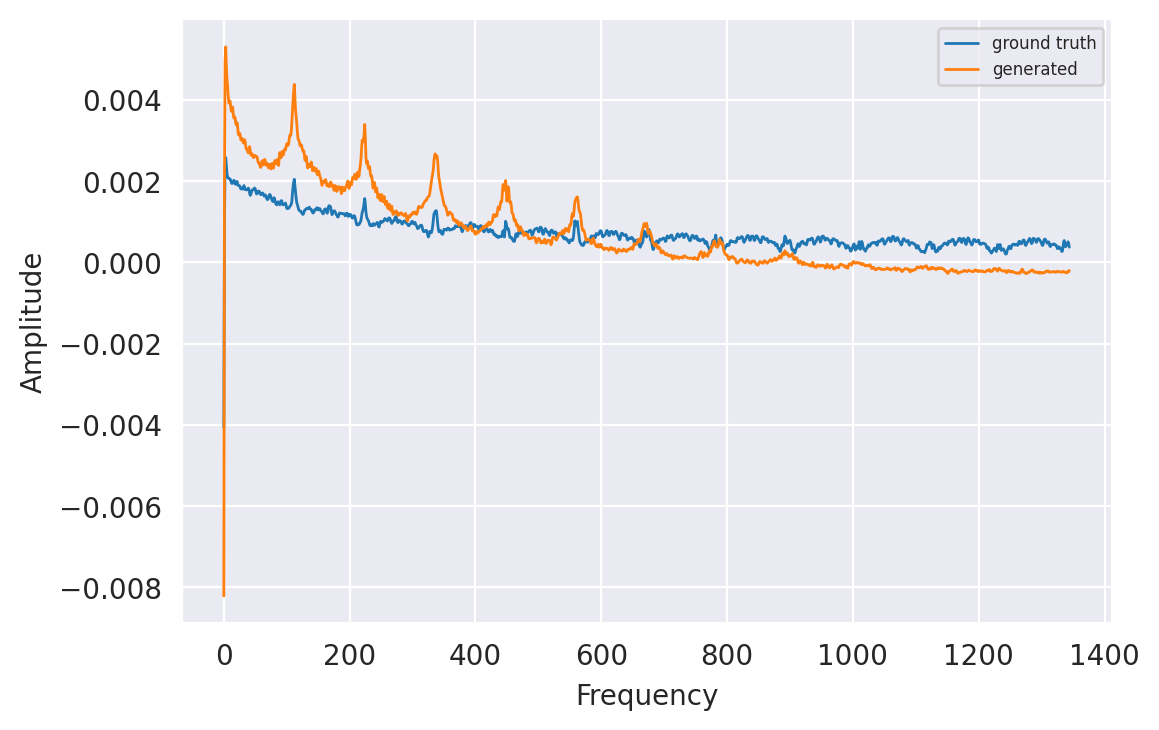

In [44]:
# seems this function is misnamed a bit, since it returns correlation (accuracy) rather than error
corrs = psc.power_spectrum_error_per_dim(gt, ts)

In [45]:
print(f"Correlations are:")
print([f"{c:.4f}" for c in corrs])

Correlations are:
['0.9477', '0.9236', '0.9194']


The correlations are close to 1, suggesting the model properly learns the data periodicities.